# Titanic: Machine Learning from Disaster
My attempt at this machine learning competition on kaggle.
I'm not very happy with my results.
Although my cross validation accuracy is as high as 83% with the training dataset (SVM, Adaboost, and Max voting classifier), my accuracy on the test set is lower: ~79%.

## Todo
 - [ ] Implement addition of noise to prevent overfitting
 - [ ] Add regularization for regressors
 - [ ] Test proper grid searches for the learners
 - [ ] Implement the pipeline of featsel -> gridsearch -> train for the learners
 - [ ] Decide on a proper feature selection method

In [53]:
#The basic numeric and data handling packages
import pandas as pd
import numpy as np

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

In [1142]:
# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Preprocessing, Xval and feature sel
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV

# PCA
from sklearn.decomposition import PCA

In [107]:
# Read the observed data
data = pd.read_csv('train.csv')
labelColumn = "Survived"
sampleIDColumn = "PassengerId"
numericData = data.select_dtypes(include=[np.number])

# Preliminary Investigation

In [206]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [542]:
# What is the distribution of the titles of the people?
data["Name"].apply(lambda x: x.split(',')[1].split(' ')[1]).value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Mlle.          2
Col.           2
the            1
Lady.          1
Jonkheer.      1
Don.           1
Mme.           1
Sir.           1
Capt.          1
Ms.            1
Name: Name, dtype: int64

In [108]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [61]:
#Do we have any NaNs in the data?
nanCount = pd.concat([data.isnull().sum(), data.notnull().sum()], axis=1)
nanFields = nanCount[0].loc[nanCount[0] > 0].index
notNanData = data.dropna()
notNanNumericData = numericData.dropna()
nanCount

,0,1
PassengerId,0,891
Survived,0,891
Pclass,0,891
Name,0,891
Sex,0,891
Age,177,714
SibSp,0,891
Parch,0,891
Ticket,0,891
Fare,0,891


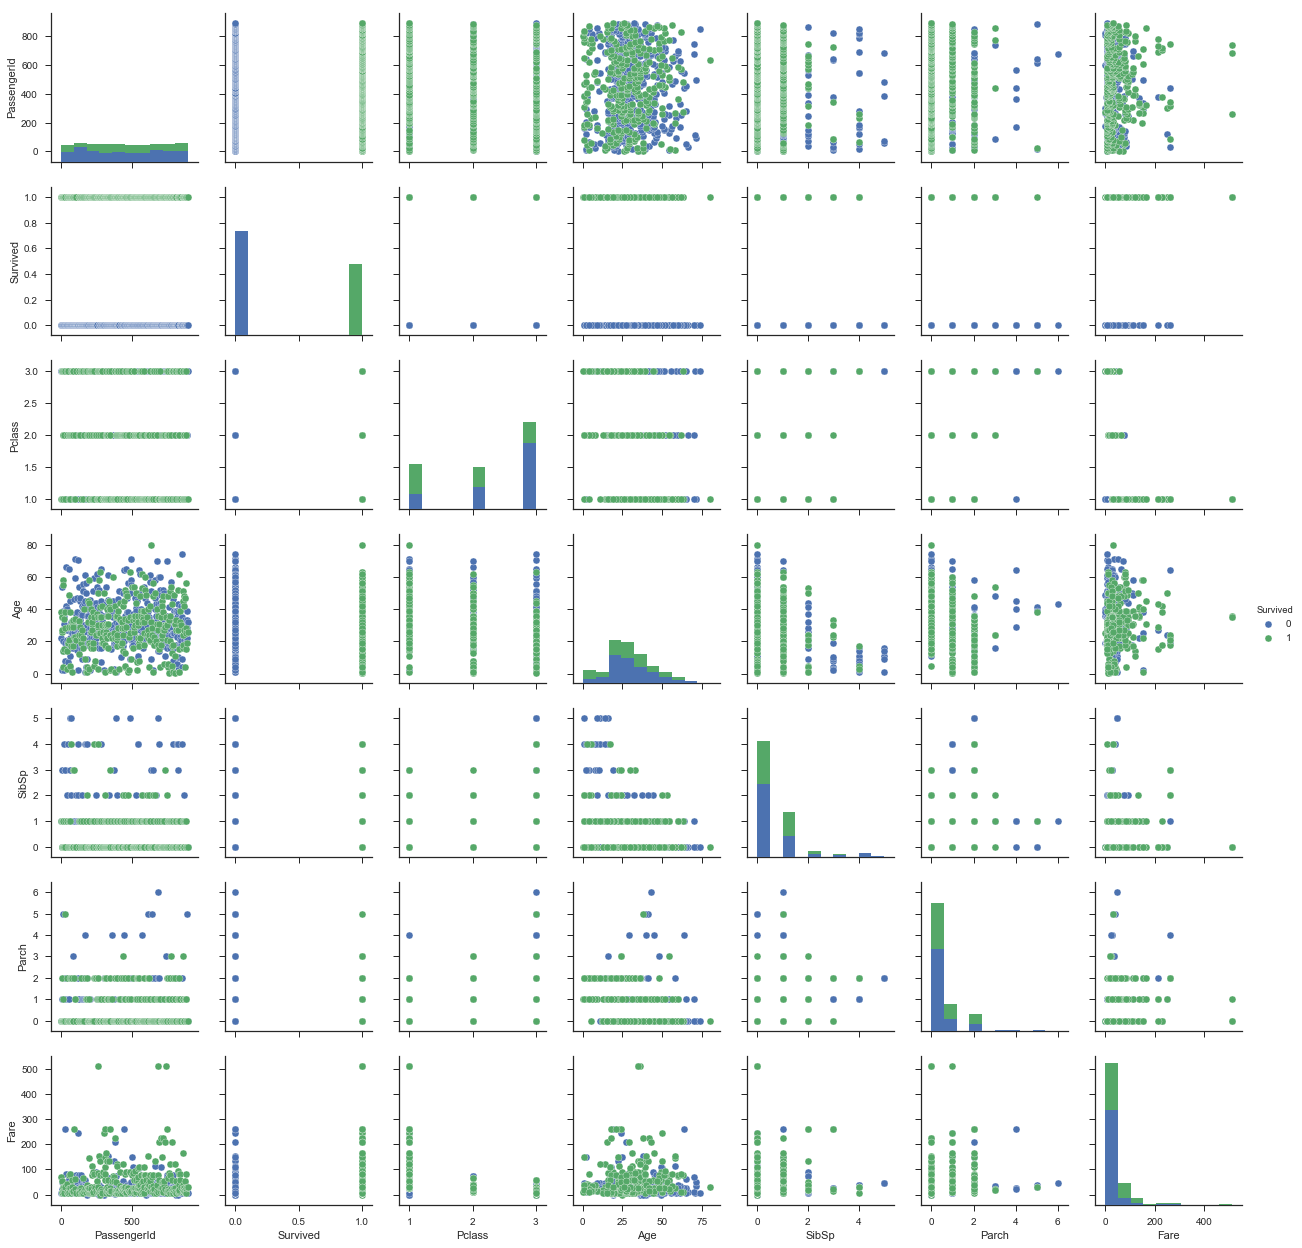

In [59]:
# Perform a pairplot of the (not NaN) numerical data
g = sns.pairplot(notNanNumericData, hue='Survived')
plt.show()

In [1260]:
def plotScatter(x='x', y='y', l=None, data=None, ax=None):
    x = x if data is None else data[x]
    y = y if data is None else data[y]
    l = l if data is None else data[l]
    if ax is not None:
        sns.regplot('x', 'y', data=pcaD, fit_reg=False, ax=ax)
    else:
        sns.regplot('x', 'y', data=pcaD, fit_reg=False)
    #fi
#edef

# Perform a PCA
def plotPCA(data, labels=None, dim1=0, dim2=1):
    pcaT  = PCA(n_components=max(dim1,dim2)+1)
    pcaE  = pcaT.fit_transform(data)
    print(pcaE[:,dim1].shape)
    pcaE  = pd.DataFrame({"x": pcaE[:,dim1], "y": pcaE[:,dim2]})
    pcaE["labels"] = labels if labels is not None else np.zeros(data.shape[0])
  
    sns.lmplot('x', 'y', data=pcaE, hue="labels", fit_reg=False)
    plt.show()
#edef

# Perform a tSNE
from sklearn.manifold import TSNE
def plotTSNE(data, labels=None):
    tsneT  = TSNE(n_components=2)
    tsneE  = pd.DataFrame(tsneT.fit_transform(data))
    tsneE.columns = ["x", "y"]
    tsneE["labels"] = labels if labels is not None else np.zeros(data.shape[0])
  
    sns.lmplot('x', 'y', data=tsneE, hue="labels", fit_reg=False)
    plt.show()
#edef

# Draw a heatmap of the correlation between the variables in the data
def correlationHeatmap(data, doMask=True):
    corr = data.corr()
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    mask = np.zeros_like(corr, dtype=np.bool)
    if doMask:
      mask[np.triu_indices_from(mask)] = True
    #fi
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(corr, center=0, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    plt.show()
#edefcorrelationHeatmap(notNanNumericData, doMask=False)

(714,)


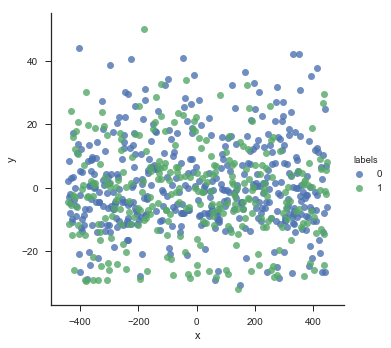

In [1267]:
plotPCA(notNanNumericData.drop([labelColumn], axis=1), labels=notNanNumericData[labelColumn].values, dim1=0, dim2=2)

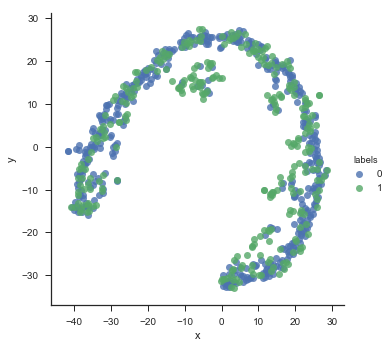

In [437]:
plotTSNE(notNanNumericData.drop([labelColumn], axis=1), notNanNumericData[labelColumn].values)

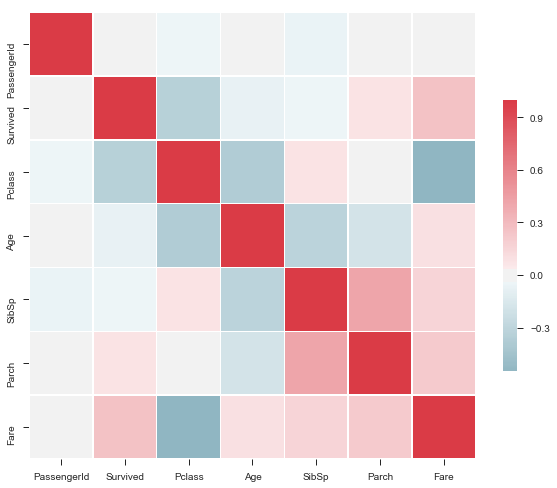

In [1245]:
correlationHeatmap(data, doMask=False)

## Pre-processing

In [933]:
embarkedPerPclass = data[["Pclass", "Embarked"]].groupby("Pclass").agg(lambda x:x.value_counts().index[0])
dict(zip(embarkedPerPclass.index, [ v[0] for v in embarkedPerPclass.values]))

{1: 'S', 2: 'S', 3: 'S'}

### Impute missing data

In [1104]:
# Only impute if we have less than 50% missing data in the field
from sklearn.preprocessing import Imputer

def mostFrequent(data):
    from collections import Counter
    return Counter(data).most_common(1)[0][0]
#edef

#def imputeAgeLogic(farePerPclass, pclass, fare):
#    # If the fare was more than average, it is adult ticket
#    # If the fare is less than average, it is child ticket
#   # If the fare is null, set to adult
#    if pd.isnull(fare):
#        return 20
#    elif fare > farePerClass[pclass]:
#        return 20
#    else:
#        return 14
#    #fi
#edef

def trainImpute(data):
    imputed = {}

    def xNormalDistPerY(data, x, y):
        dist = pd.concat([ data[[x, y]].groupby(y).mean(), data[[x, y]].groupby(y).std()], axis=1)
        dist.columns = ["mean", "stdev"]
        dist = dict(zip(dist.index, dist.values))
        return dist
    #edef
    
    fareDistPerPclass = xNormalDistPerY(data, "Fare", "Pclass")
    imputed["Fare"] = lambda x: np.random.normal(fareDistPerPclass[x["Pclass"]][0], fareDistPerPclass[x["Pclass"]][1])
    
    ageDistPerPclass = xNormalDistPerY(data, "Age", "Pclass")
    def imputeAgeLogic(sibsp, parch, pclass):
        # If the person has no sib/sp/par/ch, they are a single traveller -> probably an adult
        if sibsp + parch == 0:
            return min(16, np.random.normal(ageDistPerPclass[pclass][0], ageDistPerPclass[pclass][1]))
        # If there is a spouse/child, but no parents -> adult
        elif sibsp == 1 and parch == 0:
            return min(16, np.random.normal(ageDistPerPclass[pclass][0], ageDistPerPclass[pclass][1]))
        # More than one spouse? unliekly -> child
        elif sibsp > 1:
            return max(15, np.random.normal(ageDistPerPclass[pclass][0], ageDistPerPclass[pclass][1]))
        else:
            return np.random.normal(ageDistPerPclass[pclass][0], ageDistPerPclass[pclass][1])
        #fi
    #edef
    
    imputed["Age"] = lambda x: imputeAgeLogic(x["SibSp"], x["Parch"], x["Pclass"])
    
    embarkedPerPclass = data[["Pclass", "Embarked"]].groupby("Pclass").agg(lambda x:x.value_counts().index[0])
    embarkedPerPclass = dict(zip(embarkedPerPclass.index, [ v[0] for v in embarkedPerPclass.values]))
    imputed["Embarked"] = lambda x: embarkedPerPclass[x["Pclass"]]
    

    
    return imputed
#edef

def impute(imputed, data):
    newData = data.copy()
    for field in imputed:
        fieldImputer = imputed[field]
        print(field)
        newData["_Filled.%s" % field] = newData.apply(lambda x: fieldImputer(x) if pd.isnull(x[field]) else x[field], axis=1)
    #efor
    return newData
#edef


In [1105]:
    def xNormalDistPerY(data, x, y):
        dist = pd.concat([ data[[x, y]].groupby(y).mean(), data[[x, y]].groupby(y).std()], axis=1)
        dist.columns = ["mean", "stdev"]
        dist = dict(zip(dist.index, dist.values))
        return dist
    #edef
    
    xNormalDistPerY(data, "Age", "Pclass")

{1: array([ 38.23344086,  14.8028559 ]),
 2: array([ 29.87763006,  14.00107681]),
 3: array([ 25.14061972,  12.49539821])}

In [1106]:
imputedValues = trainImpute(data)
imputedData = impute(imputedValues, data)
imputedData.head()

Fare
Age
Embarked


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,_Filled.Fare,_Filled.Age,_Filled.Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,7.2500,22.0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,71.2833,38.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,7.9250,26.0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,53.1000,35.0,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,8.0500,35.0,S


In [1107]:
#Do we have any NaNs in the data?
pd.concat([imputedData.isnull().sum(), imputedData.notnull().sum()], axis=1)


,0,1
PassengerId,0,891
Survived,0,891
Pclass,0,891
Name,0,891
Sex,0,891
Age,177,714
SibSp,0,891
Parch,0,891
Ticket,0,891
Fare,0,891


In [1185]:
print("age known:   total->", data[data["Age"].notnull()]["Survived"].size, "survived->", data[data["Age"].notnull()]["Survived"].sum())
print("age unknown: total->", data[data["Age"].isnull()]["Survived"].size, "survived->", data[data["Age"].isnull()]["Survived"].sum())

age known:   total-> 714 survived-> 290
age unknown: total-> 177 survived-> 52


### Select and transform features

In [1207]:
# Select features that we want to use, and discard others, and transform others
def selectAndTransformFeatures(data, keepOriginal=False):
    newData = data.drop(["Ticket"], axis=1)
    # Move Gender to binary feature
    newData["Sex"] = newData["Sex"].apply(lambda x: 1 if x == "male" else 0)
    
    # Did we know the age of the person? (I think living -> age known)
    newData["KnownAge"] = newData["Age"].apply(lambda x: 0 if pd.isnull(x) else 1)

    # And create dummy features for embarked
    embarkLocations = [ "C", "S", "Q" ]
    for loc in embarkLocations:
        newData["_Dummy.Embarked%s" % loc] = newData["Embarked"].apply(lambda x: 1 if x == loc else 0)
    #fi
    
    # Add features for the titles of the people
    titleMap = { 'Capt.' : 'mr',
                 'Col.' : 'mr',
                 'Don.' : 'mr',
                 'Dr.' : 'mr',
                 'Jonkheer.' : 'mr',
                 'Lady.' : 'mrs',
                 'Major.' : 'mr',
                 'Master.' : 'master',
                 'Miss.' : 'miss',
                 'Mlle.' : 'miss',
                 'Mme.' : 'mrs',
                 'Mr.' : 'mr',
                 'Mrs.' : 'mrs',
                 'Ms.' : 'mrs',
                 'Rev.' : 'rev',
                 'Sir.' : 'mr',
                 'the' : 'mr' }
    titles = ["mr", "mrs", "master", "miss", "rev"]
    
    newData["Title"] = newData["Name"].apply(lambda x: x.split(',')[1].split(' ')[1]).replace(titleMap)
    for title in titles:
        newData["_Dummy.Title%s" % title] = newData["Title"].apply(lambda x: 1 if x == title else 0)
    #efor
    
    def getCabinDeck(cabinID):
        if pd.isnull(cabinID):
            return 'U'
        else:
            return cabinID[0]
        #fi
    #edef

    newData["Deck"] = newData["Cabin"].apply(getCabinDeck)
    decks = [ "U", "A", "B", "C", "D", "E", "F", "G", "T" ]
    for deck in decks:
        newData["_Dummy.Deck%s" % deck] = newData["Deck"].apply(lambda x: 1 if x == deck else 0)
    #efor
    
    newData["FamSize"] = newData["SibSp"] + newData["Parch"]
    
    newData["Child"] = newData["_Filled.Age"].apply(lambda x: 1 if x <= 15 else 0) 
    newData["Adult"] = newData["_Filled.Age"].apply(lambda x: 1 if x > 15 else 0)
    newData["Mother"] = newData.apply(lambda x: 1 if ((x["Sex"] == 0) and (x["_Filled.Age"] >= 18) and (x["Parch"] > 0)) else 0, axis=1)
    
    if not(keepOriginal):
        newData = newData.drop(["Cabin"], axis=1)
        newData = newData.drop(["Fare"], axis=1)
        newData = newData.drop(["Name"], axis=1)
        newData = newData.drop(newData.columns[newData.isnull().sum() > 0], axis=1)
    #fi
    
    return newData
#edef

In [1208]:
stData = selectAndTransformFeatures(imputedData)
stData.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,_Filled.Fare,_Filled.Age,_Filled.Embarked,KnownAge,...,_Dummy.DeckC,_Dummy.DeckD,_Dummy.DeckE,_Dummy.DeckF,_Dummy.DeckG,_Dummy.DeckT,FamSize,Child,Adult,Mother
0,1,0,3,1,1,0,7.2500,22.0,S,1,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,0,1,0,71.2833,38.0,C,1,...,1,0,0,0,0,0,1,0,1,0
2,3,1,3,0,0,0,7.9250,26.0,S,1,...,0,0,0,0,0,0,0,0,1,0
3,4,1,1,0,1,0,53.1000,35.0,S,1,...,1,0,0,0,0,0,1,0,1,0
4,5,0,3,1,0,0,8.0500,35.0,S,1,...,0,0,0,0,0,0,0,0,1,0


### Normalize continuous features

In [1209]:
from sklearn.preprocessing import StandardScaler

def trainNormalization(data):
    normalizers = {}
    normalizers["_Filled.Age"] = StandardScaler().fit(np.matrix(data["_Filled.Age"].values).transpose())
    normalizers["_Filled.Fare"] = StandardScaler().fit(np.matrix(data["_Filled.Fare"].values).transpose())
    return normalizers
#edef

def normalize(normalizers, data):
    newData = data.copy()
    for field in normalizers:
        fieldNorm = normalizers[field]
        newData[field] = fieldNorm.transform(np.matrix(newData[field]).transpose()).flatten()
    #efor
    return newData
#edef

In [1210]:
normalizers = trainNormalization(stData)
normalizedData = normalize(normalizers, stData)
normalizedData.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,_Filled.Fare,_Filled.Age,_Filled.Embarked,KnownAge,...,_Dummy.DeckC,_Dummy.DeckD,_Dummy.DeckE,_Dummy.DeckF,_Dummy.DeckG,_Dummy.DeckT,FamSize,Child,Adult,Mother
0,1,0,3,1,1,0,-0.502445,-0.341838,S,1,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,0,1,0,0.786845,0.759998,C,1,...,1,0,0,0,0,0,1,0,1,0
2,3,1,3,0,0,0,-0.488854,-0.066379,S,1,...,0,0,0,0,0,0,0,0,1,0
3,4,1,1,0,1,0,0.420730,0.553404,S,1,...,1,0,0,0,0,0,1,0,1,0
4,5,0,3,1,0,0,-0.486337,0.553404,S,1,...,0,0,0,0,0,0,0,0,1,0


(891,)


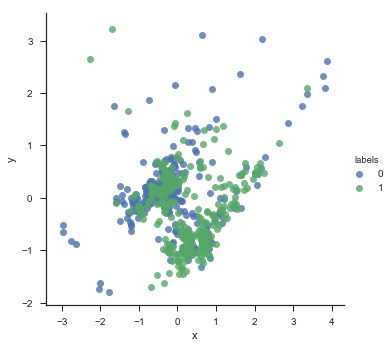

In [1271]:
plotPCA(normalizedData.drop([labelColumn], axis=1).select_dtypes([np.number]), normalizedData[labelColumn].values, dim1=4, dim2=5)

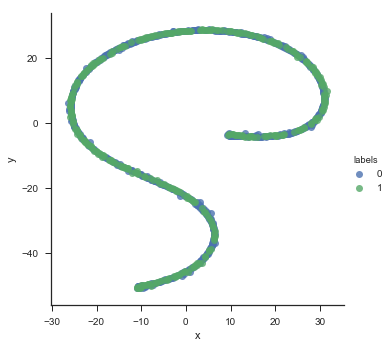

In [1212]:
plotTSNE(normalizedData.drop([labelColumn], axis=1).select_dtypes([np.number]), normalizedData[labelColumn].values)

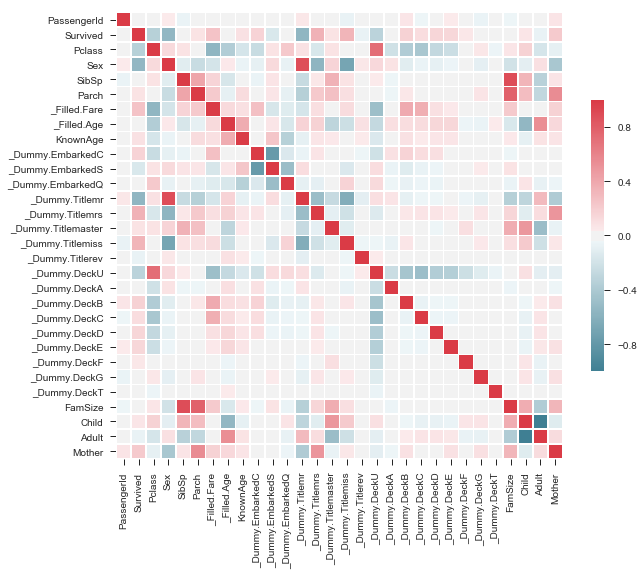

In [1243]:
correlationHeatmap(normalizedData, doMask=False)

### Add noise to variables to prevent overfitting

In [1114]:
def spNoise(value, p):
    return (1-value) if np.random.uniform() < p else value
#edef

def gaussNoise(value, p):
    return value + np.random.normal() if np.random.uniform() < p else value
#edef

def addNoise(data):
    newData = data.copy()
    
    spFields = ["KnownAge"]

## Classification

In [1213]:
# Prepare the training matrix, initially.
trainingData = normalizedData.drop([labelColumn, sampleIDColumn], axis=1)
trainingLabels = normalizedData[labelColumn]
trainingData.head()

,Pclass,Sex,SibSp,Parch,_Filled.Fare,_Filled.Age,_Filled.Embarked,KnownAge,_Dummy.EmbarkedC,_Dummy.EmbarkedS,...,_Dummy.DeckC,_Dummy.DeckD,_Dummy.DeckE,_Dummy.DeckF,_Dummy.DeckG,_Dummy.DeckT,FamSize,Child,Adult,Mother
0,3,1,1,0,-0.502445,-0.341838,S,1,0,1,...,0,0,0,0,0,0,1,0,1,0
1,1,0,1,0,0.786845,0.759998,C,1,1,0,...,1,0,0,0,0,0,1,0,1,0
2,3,0,0,0,-0.488854,-0.066379,S,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,0,1,0,0.420730,0.553404,S,1,0,1,...,1,0,0,0,0,0,1,0,1,0
4,3,1,0,0,-0.486337,0.553404,S,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [1214]:
def trainModel(model, trainData, trainLabel, cv=20):
    accuracy = cross_val_score(model, trainData, trainLabel, cv = cv)
    model.fit(trainData, trainLabel)
    return [model, accuracy]
#edef

def trainModelFS(model, trainData, trainLabel, cv=20):
    pl = Pipeline([
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
        ('classification', model)
    ])
    accuracy = cross_val_score(pl, trainData, trainLabel, cv = cv)
    pl.fit(trainData, trainLabel)
    return [pl, accuracy]
#edef

def trainModelGridSearch(model, trainData, trainLabel, gridParams, cv = 20):
    gsModel = GridSearchCV(model, gridParams)
    return trainModel(gsModel, trainData, trainLabel, cv=cv)
#edef

def predModel(model, testData):
    pred = model.predict(testData)
    return pred
#edef

### Decision tree

In [1236]:
dtInput = trainingData.select_dtypes([np.number])

In [1216]:
dtModel = DecisionTreeClassifier()
dtClf, dtXV = trainModelFS(dtModel, dtInput, trainingLabels)
print("DT XV average: %f" % (dtXV.mean()) )

DT XV average: 0.792725


### Random Forest

In [1217]:
rfInput = trainingData.select_dtypes([np.number])

In [1218]:
rfModel = RandomForestClassifier()
rfClf, rfXV = trainModelFS(rfModel, rfInput, trainingLabels)
print("RF XV average: %f" % (rfXV.mean()) )

RF XV average: 0.816111


In [1219]:
pd.DataFrame({ 'gt': trainingLabels, 'pred':cross_val_predict(rfModel, rfInput, trainingLabels)}).groupby(["gt", "pred"]).size()

gt  pred
0   0       476
    1        73
1   0        89
    1       253
dtype: int64

### Logistic Regression classifier

In [1220]:
lgcInput = trainingData.select_dtypes([np.number])

In [1221]:
lgcModel = LogisticRegression()
lgcClf, lgcXV = trainModelFS(lgcModel, lgcInput, trainingLabels)
print("LGC XV average: %f" % (lgcXV.mean()) )

LGC XV average: 0.823869


In [1222]:
pd.Series(lgcClf.get_params())

classification                                     LogisticRegression(C=1.0, class_weight=None, d...
classification__C                                                                                  1
classification__class_weight                                                                    None
classification__dual                                                                           False
classification__fit_intercept                                                                   True
classification__intercept_scaling                                                                  1
classification__max_iter                                                                         100
classification__multi_class                                                                      ovr
classification__n_jobs                                                                             1
classification__penalty                                                                    

### Logistic regression with Grid Search

In [1223]:
lgcGSModel = LogisticRegressionCV()
lgcGSClf, lgcGSXV = trainModelFS(lgcGSModel, lgcInput, trainingLabels)
print("LGC-GS XV average: %f" % (lgcGSXV.mean()) )

LGC-GS XV average: 0.823819


In [1125]:
pd.Series(lgcGSClf.get_params())

classification                                     LogisticRegressionCV(Cs=10, class_weight=None,...
classification__Cs                                                                                10
classification__class_weight                                                                    None
classification__cv                                                                              None
classification__dual                                                                           False
classification__fit_intercept                                                                   True
classification__intercept_scaling                                                                  1
classification__max_iter                                                                         100
classification__multi_class                                                                      ovr
classification__n_jobs                                                                     

### Support Vector Classifier

In [1224]:
svmInput = trainingData.select_dtypes([np.number])

In [1225]:
svmModel = SVC()
svmClf, svmXV = trainModel(svmModel, svmInput, trainingLabels)
print("SVM XV average: %f" % (svmXV.mean()) )

SVM XV average: 0.830462


In [1226]:
pd.Series(svmClf.get_params())

C                              1
cache_size                   200
class_weight                None
coef0                          0
decision_function_shape      ovr
degree                         3
gamma                       auto
kernel                       rbf
max_iter                      -1
probability                False
random_state                None
shrinking                   True
tol                        0.001
verbose                    False
dtype: object

### Linear SVC

In [1227]:
lsvcModel = LinearSVC(C=0.01, penalty="l1", dual=False)
lscvClf, lsvcXV = trainModelFS(lsvcModel, svmInput, trainingLabels)
print("LSVC XV average: %f" % (lsvcXV.mean()) )

LSVC XV average: 0.764368


### Adaboost

In [1228]:
adbInput = trainingData.select_dtypes([np.number])

In [1229]:
adbModel = AdaBoostClassifier()
adbClf, adbXV = trainModelFS(adbModel, adbInput, trainingLabels)
print("ADB XV average: %f" % (adbXV.mean()) )

ADB XV average: 0.831897


### Voting classifier

In [1230]:
vcInput = trainingData.select_dtypes([np.number])

In [1231]:
vcBasicModels = [ ('rf', rfModel), ('lgc', lgcGSModel), ('svm', svmModel), ('adb', adbModel) ]
vcPModels = [ (name, Pipeline([
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
        ('classification', model)
    ])) for (name, model) in  vcBasicModels]
vcModel = VotingClassifier(estimators = vcPModels, voting='hard')
vcClf, vcXV = trainModelFS(vcModel, vcInput, trainingLabels)
print("VC XV average: %f" % (vcXV.mean()) )

VC XV average: 0.830436


## Perform the final test for submission

In [1232]:
# Now perform tests on the final data
testData = pd.read_csv('test.csv')
testData.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Prepare the data

In [1233]:
imputedTestData    = impute(imputedValues, testData)
stTestData         = selectAndTransformFeatures(imputedTestData)
normalizedTestData = normalize(normalizers, stTestData)

Fare
Age
Embarked


### Predict and write

In [1235]:
predLabels = predModel(lgcGSClf, normalizedTestData.select_dtypes([np.number]).drop(["PassengerId"], axis=1))
submission = pd.DataFrame({ "PassengerId" : normalizedTestData["PassengerId"],
                            "Survived" : predLabels})
submission.to_csv("submission.csv", index=False)